# Combinación de datos de LAFIFA vs Encuentros de Europa
En este cuaderno se realiza el proceso para combinar las características obtenidas de los equipos deportivos de la pagina “fifaindex.com”, con los datos obtenidos de la pagina “livefutbol.com” que contienen los encuentros de los equipos seleccionados de Europa.

# Setting Preliminares

Importar las librerías básicas.

In [ ]:
# carga de datos
import pandas as pd
import io
from google.colab import files

# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from numpy import corrcoef, transpose, arange
from pylab import pcolor, show, colorbar, xticks, yticks

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
pd.options.mode.chained_assignment = None



# Carga de Datos

Función de Google Colab para cargar datos.
Subimos los datos de entrenamiento sin campo objetivo (dengue_features_train)

In [ ]:
def upload_files ():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

In [ ]:
#europa_promedio_goles.csv
df = upload_files() 
df.head()

Saving europa_promedio_goles_2.csv to europa_promedio_goles_2 (1).csv
User uploaded file "europa_promedio_goles_2.csv" with length 705148 bytes


,jornada,fecha,puntos_actuales,equipo,liga,entrenador_nuevo,promedio_goles_hechos_antes_de_cambio_entrenador_1_5,promedio_goles_hechos_despues_de_cambio_entrenador_1_5,promedio_goles_recibidos_antes_de_cambio_entrenador_1_5,promedio_goles_recibidos_despues_de_cambio_entrenador_1_5,puntos_hechos_antes_de_cambio_entrenador_1_5,puntos_hechos_despues_de_cambio_entrenador_1_5,porcentaje_victorias_despues_de_cambio_entrenador_1_5,porcentaje_victorias_antes_de_cambio_entrenador_1_5,porcentaje_empates_despues_de_cambio_entrenador_1_5,porcentaje_empates_antes_de_cambio_entrenador_1_5,porcentaje_derrotas_despues_de_cambio_entrenador_1_5,porcentaje_derrotas_antes_de_cambio_entrenador_1_5
0,1,09-08-2009,1,SC Freiburg,bundesliga,Robin Dutt,1.4,0.8,2.8,2.4,1,4,0.2,0.0,0.2,0.2,0.6,0.8
1,1,06-08-2011,1,SC Freiburg,bundesliga,Marcus Sorg,0.6,1.8,1.8,3.2,3,4,0.2,0.2,0.2,0.0,0.6,0.8
2,18,21-01-2012,16,SC Freiburg,bundesliga,Christian Streich,1.0,1.2,2.4,1.6,3,5,0.2,0.0,0.4,0.6,0.4,0.4
3,1,26-08-2018,0,RB Leipzig,bundesliga,Ralf Rangnick,2.6,1.6,2.4,1.6,7,8,0.4,0.4,0.4,0.2,0.2,0.4
4,1,18-08-2019,3,RB Leipzig,bundesliga,Julian Nagelsmann,1.6,2.6,1.4,0.6,8,13,0.8,0.4,0.2,0.4,0.0,0.2


In [ ]:
#fifa_caracteristicas_equipos.csv
fifa = upload_files() 
fifa.head()

Saving fifa_caracteristicas_equipos.csv to fifa_caracteristicas_equipos (2).csv
User uploaded file "fifa_caracteristicas_equipos.csv" with length 478640 bytes


,equipo,liga,ataque,medio,defensa,promedio,año
0,Milan,Serie A italiana,91,91,91,91,2005
1,Arsenal,Liga Inglesa,92,92,92,92,2005
2,Real Madrid C.F.,LFP 1ª División,91,91,91,91,2005
3,Manchester United,Liga Inglesa,91,91,91,91,2005
4,Juventus,Serie A italiana,92,92,92,92,2005


In [ ]:
print(df.shape)
print(fifa.shape)

(6977, 18)
(10350, 7)


Ver variables númericas

# Inicio de proceso de fusión de Datasets.

In [ ]:
#funcion para quitar tildes y ñ
def quitar_tildes(x):
  x = x.replace('á','a')
  x = x.replace('é', 'e')
  x = x.replace('í', 'i')
  x = x.replace('ó', 'o')
  x = x.replace('ú', 'u')
  x = x.replace('Á','A')
  x = x.replace('É', 'E')
  x = x.replace('Í', 'I')
  x = x.replace('Ó', 'O')
  x = x.replace('Ú', 'U')
  x = x.replace('ã','a')
  x = x.replace('ê','e')
  x = x.replace('ñ','n')
  x = x.replace('Ñ','N')
  return x

Remover caracteres especiales del Dataset “df” y "fifa", y combinación datasets. 

In [ ]:
ataque = [None]*len(df)
medio = [None]*len(df)
defensa = [None]*len(df)

#recorrer dataframe principal
for fila_df in list(range(len(df))):
  fecha_df=df['fecha'][fila_df].split('-')[2]
  for fila_fifa in list(range(len(fifa))):
    x = df['equipo'][fila_df]
    y = fifa['equipo'][fila_fifa]
    #quitar caracteres especiales
    x = ''.join(filter(str.isalnum, x))
    y = ''.join(filter(str.isalnum, y))
    #quitar tildes y simbolos extraños
    x = quitar_tildes(x)
    y = quitar_tildes(y)
    #quitar mayusculas
    x = x.lower()
    y = y.lower()
    #Comparar club del dataset "df" con club del dataset "fifa"
    #recorrer fataframe fifa
    if int(fecha_df) == fifa['año'][fila_fifa]:
      if x in y or y in x:
        ataque[fila_df] = fifa['ataque'][fila_fifa]
        medio[fila_df] = fifa['medio'][fila_fifa]
        defensa[fila_df] = fifa['defensa'][fila_fifa]
df['ataque']=ataque
df['medio']=medio
df['defensa']=defensa

# Limpieza de datos perdidos en Dataset unificado.
Porcentaje de datos perdidos “NaN” en el Dataset "df".

In [ ]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

jornada - 0%
fecha - 0%
puntos_actuales - 0%
equipo - 0%
liga - 0%
entrenador_nuevo - 0%
promedio_goles_hechos_antes_de_cambio_entrenador_1_5 - 0%
promedio_goles_hechos_despues_de_cambio_entrenador_1_5 - 0%
promedio_goles_recibidos_antes_de_cambio_entrenador_1_5 - 0%
promedio_goles_recibidos_despues_de_cambio_entrenador_1_5 - 0%
puntos_hechos_antes_de_cambio_entrenador_1_5 - 0%
puntos_hechos_despues_de_cambio_entrenador_1_5 - 0%
porcentaje_victorias_despues_de_cambio_entrenador_1_5 - 0%
porcentaje_victorias_antes_de_cambio_entrenador_1_5 - 0%
porcentaje_empates_despues_de_cambio_entrenador_1_5 - 0%
porcentaje_empates_antes_de_cambio_entrenador_1_5 - 0%
porcentaje_derrotas_despues_de_cambio_entrenador_1_5 - 0%
porcentaje_derrotas_antes_de_cambio_entrenador_1_5 - 0%
ataque - 14%
medio - 14%
defensa - 14%


Mapa de calor para reconocer datos perdidos en el Dataset “df”.

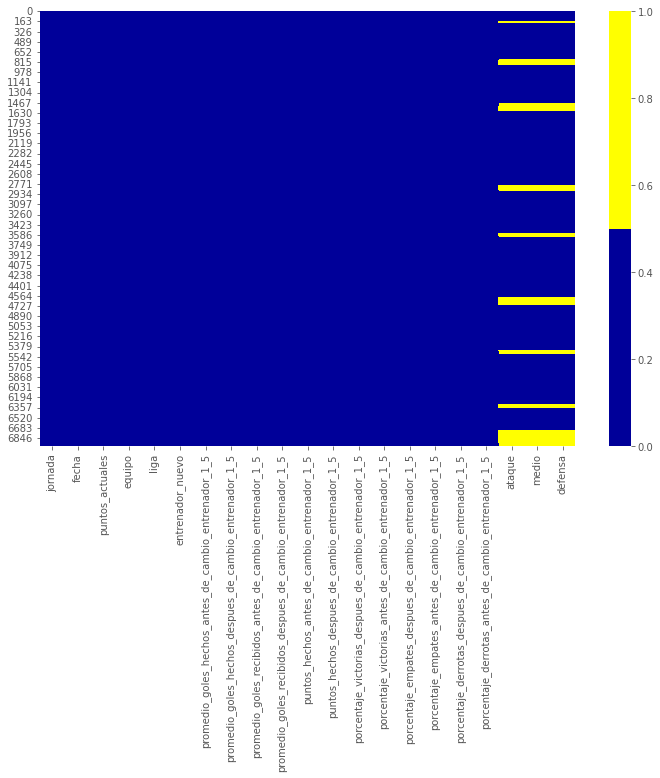

In [ ]:
cols = df.columns[:21] # primeras columnas
colours = ['#000099', '#ffff00'] # amarillo para los perdidos y azul para los no perdidos
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [ ]:
df.head(10)

,jornada,fecha,puntos_actuales,equipo,liga,entrenador_nuevo,promedio_goles_hechos_antes_de_cambio_entrenador_1_5,promedio_goles_hechos_despues_de_cambio_entrenador_1_5,promedio_goles_recibidos_antes_de_cambio_entrenador_1_5,promedio_goles_recibidos_despues_de_cambio_entrenador_1_5,...,puntos_hechos_despues_de_cambio_entrenador_1_5,porcentaje_victorias_despues_de_cambio_entrenador_1_5,porcentaje_victorias_antes_de_cambio_entrenador_1_5,porcentaje_empates_despues_de_cambio_entrenador_1_5,porcentaje_empates_antes_de_cambio_entrenador_1_5,porcentaje_derrotas_despues_de_cambio_entrenador_1_5,porcentaje_derrotas_antes_de_cambio_entrenador_1_5,ataque,medio,defensa
0,1,09-08-2009,1,SC Freiburg,bundesliga,Robin Dutt,1.4,0.8,2.8,2.4,...,4,0.2,0.0,0.2,0.2,0.6,0.8,69.0,69.0,69.0
1,1,06-08-2011,1,SC Freiburg,bundesliga,Marcus Sorg,0.6,1.8,1.8,3.2,...,4,0.2,0.2,0.2,0.0,0.6,0.8,69.0,69.0,69.0
2,18,21-01-2012,16,SC Freiburg,bundesliga,Christian Streich,1.0,1.2,2.4,1.6,...,5,0.2,0.0,0.4,0.6,0.4,0.4,69.0,69.0,69.0
3,1,26-08-2018,0,RB Leipzig,bundesliga,Ralf Rangnick,2.6,1.6,2.4,1.6,...,8,0.4,0.4,0.4,0.2,0.2,0.4,78.0,78.0,78.0
4,1,18-08-2019,3,RB Leipzig,bundesliga,Julian Nagelsmann,1.6,2.6,1.4,0.6,...,13,0.8,0.4,0.2,0.4,0.0,0.2,80.0,80.0,80.0
5,1,15-08-2021,0,RB Leipzig,bundesliga,Jesse Marsch,1.6,1.2,1.8,1.4,...,4,0.2,0.2,0.2,0.2,0.6,0.6,78.0,78.0,78.0
6,15,11-12-2021,21,RB Leipzig,bundesliga,Domenico Tedesco,1.0,2.2,1.8,1.0,...,10,0.6,0.2,0.2,0.2,0.2,0.6,78.0,78.0,78.0
7,1,08-08-2009,1,Mainz,bundesliga,Thomas Tuchel,1.6,1.4,2.2,1.4,...,8,0.4,0.2,0.4,0.2,0.2,0.6,70.0,70.0,70.0
8,1,24-08-2014,1,Mainz,bundesliga,Kasper Hjulmand,2.2,1.8,1.8,1.0,...,9,0.4,0.6,0.6,0.0,0.0,0.4,76.0,76.0,76.0
9,22,21-02-2015,25,Mainz,bundesliga,Martin Schmidt,1.8,1.6,1.8,1.2,...,8,0.4,0.2,0.4,0.2,0.2,0.6,77.0,77.0,77.0


In [ ]:
# funcion para detectar NaN o nan
def isNaN(num):
    return num != num

In [ ]:
#Completar caracteristicas
equipo = df['equipo'][0]
ataque = df['ataque'][0]
medio = df['medio'][0]
defensa = df['defensa'][0]
for filas in list(range(len(df))):
  if df['equipo'][filas] == equipo and isNaN(df['ataque'][filas]): 

    df['ataque'][filas] = ataque
    df['medio'][filas] = medio
    df['defensa'][filas] = defensa
  
  else:
    equipo = df['equipo'][filas]
    ataque = df['ataque'][filas]
    medio = df['medio'][filas]
    defensa = df['defensa'][filas]

In [ ]:
#Completar caracteristicas
equipo = df['equipo'][len(df)-1]
ataque = df['ataque'][len(df)-1]
medio = df['medio'][len(df)-1]
defensa = df['defensa'][0]
for filas in list(range(len(df)-1,-1,-1)):
  if df['equipo'][filas] == equipo and isNaN(df['ataque'][filas]): 

    df['ataque'][filas] = ataque
    df['medio'][filas] = medio
    df['defensa'][filas] = defensa
  
  else:
    equipo = df['equipo'][filas]
    ataque = df['ataque'][filas]
    medio = df['medio'][filas]
    defensa = df['defensa'][filas]

In [ ]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

jornada - 0%
fecha - 0%
puntos_actuales - 0%
equipo - 0%
liga - 0%
entrenador_nuevo - 0%
promedio_goles_hechos_antes_de_cambio_entrenador_1_5 - 0%
promedio_goles_hechos_despues_de_cambio_entrenador_1_5 - 0%
promedio_goles_recibidos_antes_de_cambio_entrenador_1_5 - 0%
promedio_goles_recibidos_despues_de_cambio_entrenador_1_5 - 0%
puntos_hechos_antes_de_cambio_entrenador_1_5 - 0%
puntos_hechos_despues_de_cambio_entrenador_1_5 - 0%
porcentaje_victorias_despues_de_cambio_entrenador_1_5 - 0%
porcentaje_victorias_antes_de_cambio_entrenador_1_5 - 0%
porcentaje_empates_despues_de_cambio_entrenador_1_5 - 0%
porcentaje_empates_antes_de_cambio_entrenador_1_5 - 0%
porcentaje_derrotas_despues_de_cambio_entrenador_1_5 - 0%
porcentaje_derrotas_antes_de_cambio_entrenador_1_5 - 0%
ataque - 0%
medio - 0%
defensa - 0%


In [ ]:
df = df.dropna(subset=["ataque"])

# Generación de Dataset de salida.

In [ ]:
#Descargar dataframe
from google.colab import files

with open('europa_promedio_goles_fifa.csv', 'w') as f:
  df.to_csv(f,  index = False)
  
files.download('europa_promedio_goles_fifa.csv')
#files.download('europa_femenina_promedio_goles.csv')
#files.download('latinoamerica_promedio_goles.csv')

df.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,jornada,fecha,puntos_actuales,equipo,liga,entrenador_nuevo,promedio_goles_hechos_antes_de_cambio_entrenador_1_5,promedio_goles_hechos_despues_de_cambio_entrenador_1_5,promedio_goles_recibidos_antes_de_cambio_entrenador_1_5,promedio_goles_recibidos_despues_de_cambio_entrenador_1_5,...,puntos_hechos_despues_de_cambio_entrenador_1_5,porcentaje_victorias_despues_de_cambio_entrenador_1_5,porcentaje_victorias_antes_de_cambio_entrenador_1_5,porcentaje_empates_despues_de_cambio_entrenador_1_5,porcentaje_empates_antes_de_cambio_entrenador_1_5,porcentaje_derrotas_despues_de_cambio_entrenador_1_5,porcentaje_derrotas_antes_de_cambio_entrenador_1_5,ataque,medio,defensa
0,1,09-08-2009,1,SC Freiburg,bundesliga,Robin Dutt,1.4,0.8,2.8,2.4,...,4,0.2,0.0,0.2,0.2,0.6,0.8,69.0,69.0,69.0
1,1,06-08-2011,1,SC Freiburg,bundesliga,Marcus Sorg,0.6,1.8,1.8,3.2,...,4,0.2,0.2,0.2,0.0,0.6,0.8,69.0,69.0,69.0
2,18,21-01-2012,16,SC Freiburg,bundesliga,Christian Streich,1.0,1.2,2.4,1.6,...,5,0.2,0.0,0.4,0.6,0.4,0.4,69.0,69.0,69.0
3,1,26-08-2018,0,RB Leipzig,bundesliga,Ralf Rangnick,2.6,1.6,2.4,1.6,...,8,0.4,0.4,0.4,0.2,0.2,0.4,78.0,78.0,78.0
4,1,18-08-2019,3,RB Leipzig,bundesliga,Julian Nagelsmann,1.6,2.6,1.4,0.6,...,13,0.8,0.4,0.2,0.4,0.0,0.2,80.0,80.0,80.0
